## Inference

In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
import matplotlib.patches as patches
from matplotlib import pyplot as plt

# import model SSD/Mobilenetv1
from models.keras_ssd300_mobilenetv1 import ssd_300

from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from extra_files import helper

%matplotlib inline

Using TensorFlow backend.


In [2]:
## Parameteres needed for ssd_300() and SSDInputEncoder()

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [1., 1., 1.] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
divide_by_stddev = [127.5, 127.5, 127.5]
swap_channels = False # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [16, 30, 60, 100, 150, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True
confidence_thresh=0.5

In [3]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='inference',
                alpha=.75,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels,
               confidence_thresh=confidence_thresh)

# 2: Load some weights into the model.
model.load_weights('/home/aldo/Documents/weights/light_models/PASCAL/mobilenet_v1_alpha_0.75.h5', by_name=True)

adam = Adam(lr=0.001)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [26]:
from scipy import misc
img = imread('./images/test103.jpg')
predictions = np.zeros(shape=(1, 200, 6))
input_ = []
height = img.shape[0]
width = img.shape[1]
resized_img= misc.imresize(img, size=(300, 300))
input_.append(resized_img)
input_ = np.array(input_)
input_ = input_.reshape(-1, 300, 300, 3)
pred = model.predict(input_)
predictions = np.append(predictions, pred, axis=0)

predictions = predictions[1:] # delete empty item
 
# Remove class and confidence from predictions
predictions = helper.clean_predictions(predictions, id_class=1)
predictions = helper.adjust_predictions(predictions)
predictions = helper.get_coordinates(predictions)

/home/aldo/anaconda3/envs/tensor/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  import sys


In [27]:
# change values to original image size
pred_bb = []
for bb in predictions[0]:
    xmin = (bb[0] / 300) * width
    ymin = (bb[1] / 300) * height
    xmax = (bb[2] / 300) * width
    ymax = (bb[3] / 300) * height
#     pred_bb.append([bb[0] * width, bb[1] * height, bb[2] * width, bb[3] * height])
    pred_bb.append([xmin, ymin, xmax, ymax])

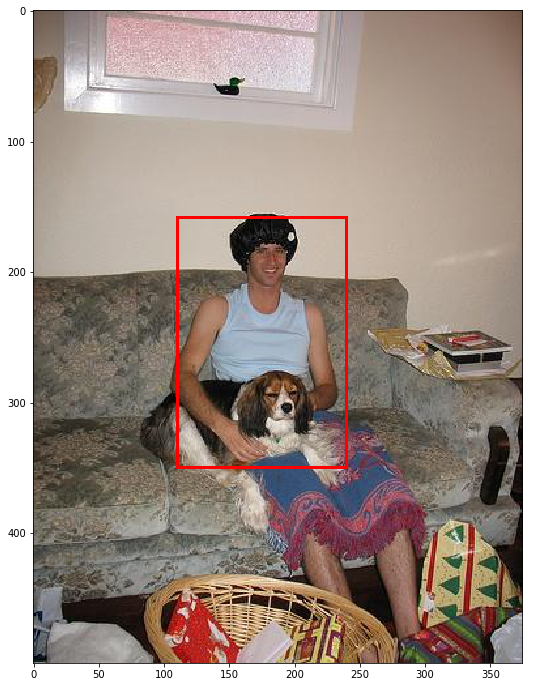

In [28]:
helper.show_image_bb(img, pred_bb)